In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


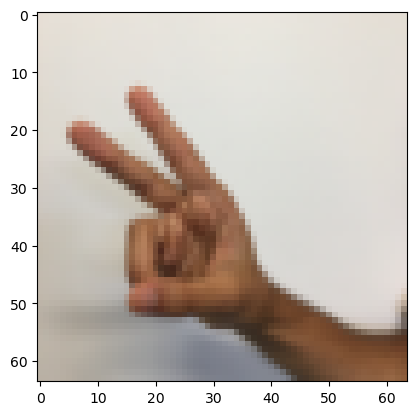

In [5]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [7]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [9]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    ### START CODE HERE ### (≈2 lines)
    X = tf.TensorSpec(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32)
    Y = tf.TensorSpec(shape=[None, n_y], dtype=tf.float32)
    ### END CODE HERE ###
    
    return X, Y

In [11]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)
Y = TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)


In [13]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    initializer = tf.keras.initializers.GlorotUniform(seed=1)
    W1 = tf.Variable(initializer(shape=(4, 4, 3, 8)), trainable=True, name="W1")
    W2 = tf.Variable(initializer(shape=(2, 2, 8, 16)), trainable=True, name="W2")
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [15]:
parameters = initialize_parameters()
# Check specific elements of W1 and W2
print("W1[1,1,1] =", parameters["W1"][1, 1, 1].numpy())  # Convert Tensor to NumPy for printing
print("W2[1,1,1] =", parameters["W2"][1, 1, 1].numpy())

W1[1,1,1] = [-0.07297277  0.04355428 -0.0658147   0.04896635  0.06719168  0.15787889
  0.00253935  0.08261944]
W2[1,1,1] = [ 0.1919449  -0.05628496 -0.1297453  -0.093014   -0.14830768  0.19019622
 -0.09055126  0.09372121 -0.03170478  0.08754992  0.07513338  0.1628921
  0.00530177  0.07907039 -0.13447177 -0.22707456]


In [17]:
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    W2 = parameters['W2']

    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool2d(A1, ksize=8, strides=8, padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool2d(A2, ksize=4, strides=4, padding='SAME')
    # FLATTEN
    P2_flattened = tf.reshape(P2, [P2.shape[0], -1])  # Flatten while keeping batch size
    # FULLY-CONNECTED without non-linear activation function
    Z3 = tf.keras.layers.Dense(6, activation=None)(P2_flattened)
    ### END CODE HERE ###

    return Z3

In [19]:
# Main Execution
np.random.seed(1)
tf.random.set_seed(1)

# Create example inputs
X_input = tf.random.normal([2, 64, 64, 3])  # Example input tensor
parameters = initialize_parameters()
Z3 = forward_propagation(X_input, parameters)

# Print the result
print("Z3 =", Z3.numpy())

Z3 = [[ 1.1516829   1.0480745   0.86547667  0.382222    0.18759553 -1.0472085 ]
 [ 0.9830084   1.0896772   0.99412346  0.21589063  0.10498679 -1.3689249 ]]


In [21]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    ### END CODE HERE ###
    
    return cost

In [43]:
# Main Execution
np.random.seed(1)
tf.random.set_seed(1)

# Create example inputs
X_input = tf.random.normal([4, 64, 64, 3])  # Input tensor
Y_input = tf.random.normal([4, 6])          # Example labels

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
# Initialize parameters
parameters = initialize_parameters()

# Forward propagation
Z3 = forward_propagation(X_input, parameters)

# Compute cost
cost = compute_cost(Z3, Y_input)

# Print the cost
print("cost =", cost.numpy())

cost = -3.4331038


In [45]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    tf.random.set_seed(1)  # to keep results consistent
    seed = 3               # to keep results consistent
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []

    # Create the model variables
    parameters = initialize_parameters()

    # Create a dataset using tf.data for easier batch processing
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(buffer_size=m, seed=seed).batch(minibatch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(minibatch_size)

    # Initialize optimizer and loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        minibatch_cost = 0.0

        for (minibatch_X, minibatch_Y) in train_dataset:
            with tf.GradientTape() as tape:
                Z3 = forward_propagation(minibatch_X, parameters)
                cost = compute_cost(Z3, minibatch_Y)

            grads = tape.gradient(cost, parameters.values())
            optimizer.apply_gradients(zip(grads, parameters.values()))
            minibatch_cost += cost.numpy() / len(train_dataset)

        # Print cost every epoch
        if print_cost and epoch % 5 == 0:
            print(f"Cost after epoch {epoch}: {minibatch_cost:.4f}")
        costs.append(minibatch_cost)

    # Plot the cost
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title(f"Learning rate = {learning_rate}")
        plt.show()

    # Compute accuracy
    def compute_accuracy(dataset):
        total_correct = 0
        total_samples = 0
        for (minibatch_X, minibatch_Y) in dataset:
            Z3 = forward_propagation(minibatch_X, parameters)
            predictions = tf.argmax(Z3, axis=1)
            labels = tf.argmax(minibatch_Y, axis=1)
            total_correct += tf.reduce_sum(tf.cast(predictions == labels, tf.float32)).numpy()
            total_samples += minibatch_Y.shape[0]
        return total_correct / total_samples

    train_accuracy = compute_accuracy(train_dataset)
    test_accuracy = compute_accuracy(test_dataset)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return train_accuracy, test_accuracy, parameters


Cost after epoch 0: 1.7970
Cost after epoch 5: 1.7918
Cost after epoch 10: 1.7918
Cost after epoch 15: 1.7918
Cost after epoch 20: 1.7918
Cost after epoch 25: 1.7918
Cost after epoch 30: 1.7918
Cost after epoch 35: 1.7918
Cost after epoch 40: 1.7918
Cost after epoch 45: 1.7918
Cost after epoch 50: 1.7918
Cost after epoch 55: 1.7918
Cost after epoch 60: 1.7918
Cost after epoch 65: 1.7918
Cost after epoch 70: 1.7918
Cost after epoch 75: 1.7918
Cost after epoch 80: 1.7918
Cost after epoch 85: 1.7918
Cost after epoch 90: 1.7918
Cost after epoch 95: 1.7918


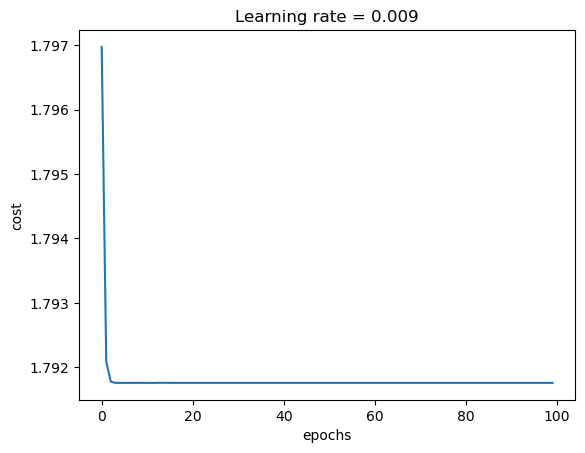

Train Accuracy: 0.1667
Test Accuracy: 0.1667


In [47]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
